# Proyecto Final - Big Data
## Estudiante Sergio Castillo

El objetivo de este proyecto es conectarse a una BD PostgreSQL donde se encuentra un dataset para aplicacion de algoritmos de machine learning utilizando pyspark.

El dataset se llama Abalone, contiene datos obtenidos de mediciones realizadas sobre abalones, los cuales son un tipo de moluscos comunes a la isla de Tasmania. El objetivo del estudio es tratar de predecir la edad de los animas en anhos a partir de los siguientes datos:


	Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years
    
El parametro mas comun para obtener la edad del animal es cortar la concha del animal, limpiarla y contar la cantidad de anillos que son visibles solo por medio de microscopio. Es un trabajo arduo y aburrido para los investigadores, por tanto la idea es poder predecir la edad a partir de otros parametros mas sencillos de obtener.

El dataset es tomado de https://archive.ics.uci.edu/ml/datasets/Abalone

In [1]:
import findspark
import os

from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, udf 
from pyspark.sql.types import DateType

spark = SparkSession.builder.appName("Basic JDBC pipeline") \
        .config("spark.driver.extraClassPath", "C:/postgresql-42.2.9.jar").getOrCreate()
            

findspark.init('C:\spark\spark-2.4.4-bin-hadoop2.7')

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://192.168.19.128/postgres") \
    .option("user", "sergio") \
    .option("password", "postgres") \
    .option("dbtable", "abalone") \
    .load()


df.show()

+---+------+--------+------+------------+--------------+--------------+------------+--------+
|sex|length|diameter|height|whole_weight|shucked_weight|viscera_weight|shell_weight|ring_age|
+---+------+--------+------+------------+--------------+--------------+------------+--------+
|  M| 0.455|   0.365| 0.095|       0.514|        0.2245|         0.101|        0.15|      15|
|  M|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|       7|
|  F|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|       9|
|  M|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|      10|
|  I|  0.33|   0.255|  0.08|       0.205|        0.0895|        0.0395|       0.055|       7|
|  I| 0.425|     0.3| 0.095|      0.3515|         0.141|        0.0775|        0.12|       8|
|  F|  0.53|   0.415|  0.15|      0.7775|         0.237|        0.1415|        0.33|      20|
|  F| 0.545|   0.425| 0.125|       0.768|         0.294|    

In [87]:
# Verifiquemos el esquema
df.printSchema()

root
 |-- sex: string (nullable = true)
 |-- length: double (nullable = true)
 |-- diameter: double (nullable = true)
 |-- height: double (nullable = true)
 |-- whole_weight: double (nullable = true)
 |-- shucked_weight: double (nullable = true)
 |-- viscera_weight: double (nullable = true)
 |-- shell_weight: double (nullable = true)
 |-- ring_age: integer (nullable = true)



In [88]:
#Algo de analisis descriptivo
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
sex,4177,None,None,F,M
length,4177,0.5239920995930099,0.12009291256479936,0.075,0.815
diameter,4177,0.407881254488869,0.09923986613365941,0.055,0.65
height,4177,0.1395163993296614,0.04182705660725731,0.0,1.13
whole_weight,4177,0.82874215944458,0.49038901823099795,0.002,2.8255
shucked_weight,4177,0.35936748862820106,0.22196294903322014,0.001,1.488
viscera_weight,4177,0.18059360785252604,0.10961425025968445,5.0E-4,0.76
shell_weight,4177,0.23883085946851795,0.13920266952238622,0.0015,1.005
ring_age,4177,9.933684462532918,3.2241690320681315,1,29


#### One hot encoding para la variable sexo

In [23]:
# One hot encoding de sexo
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

stringIndexer = StringIndexer(inputCol="sex", outputCol="sex_idx")
model = stringIndexer.fit(df)
indexed = model.transform(df)
encoder = OneHotEncoder(dropLast=False, inputCol="sex_idx", outputCol="sex_vector")
encoded = encoder.transform(indexed)
columns_to_drop = ["sex", "sex_idx"]
encoded = encoded.drop(*columns_to_drop).withColumnRenamed("ring_age", "label")
encoded = encoded['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'sex_vector', 'label']
encoded.head()

Row(length=0.455, diameter=0.365, height=0.095, whole_weight=0.514, shucked_weight=0.2245, viscera_weight=0.101, shell_weight=0.15, sex_vector=SparseVector(3, {0: 1.0}), label=15)

#### Revisemos la distribucion de los datos

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002580CA69148>,
      dtype=object)

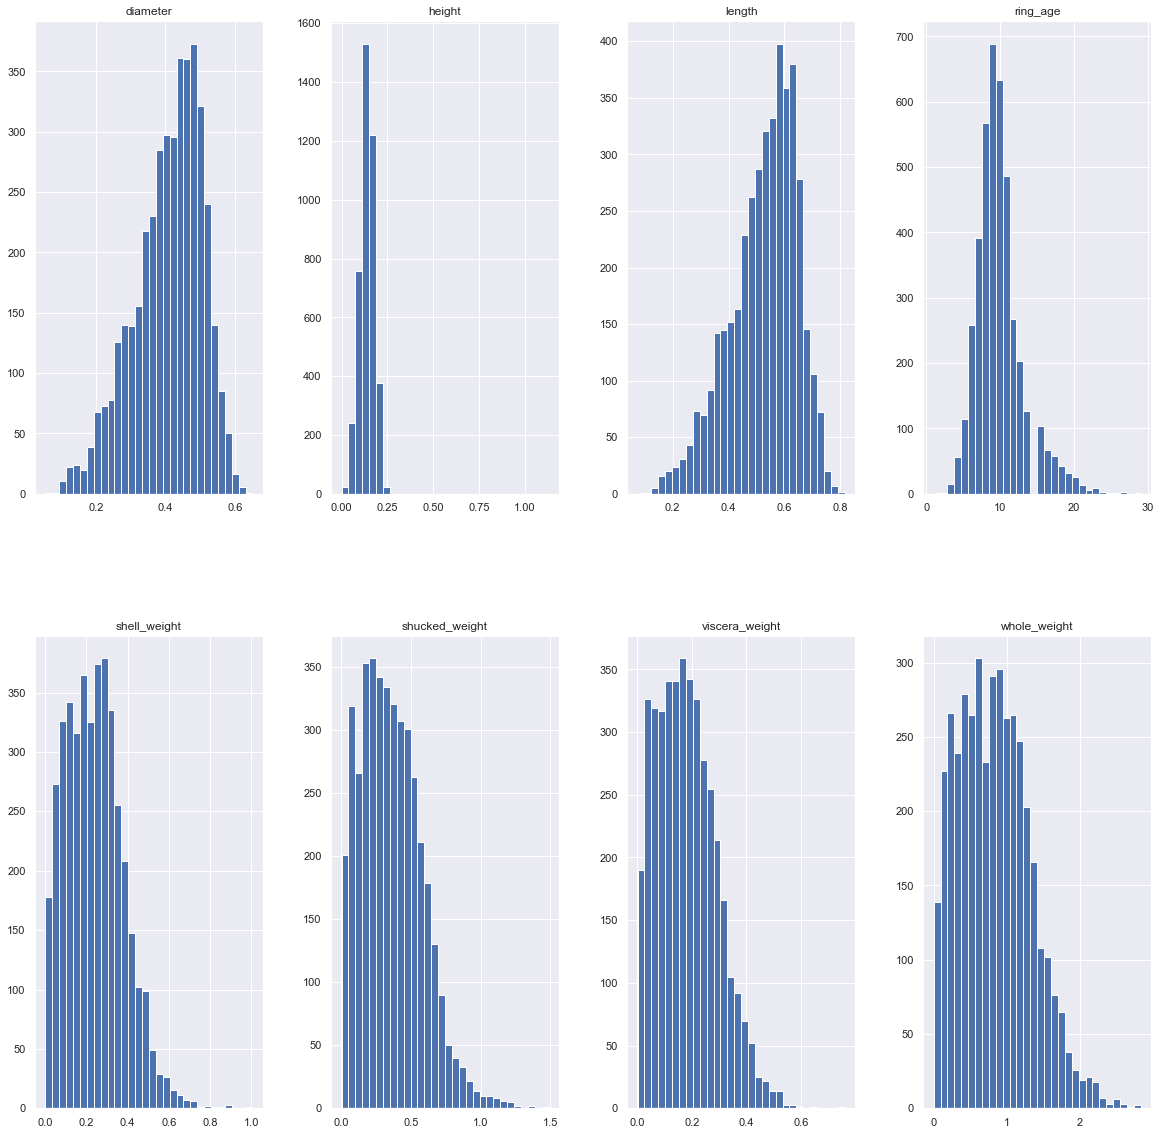

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

pdf = df.toPandas()
pdf.hist(figsize=(20,20), grid = True, layout = (2,4), bins = 30)

#### Parece que Height tiene algunos valores dispersos, procederemos a eliminarlos.

In [76]:
encoded = encoded.where(encoded.height < 0.32)
encoded.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
length,4175,0.5239652694610782,0.12008425205170487,0.075,0.815
diameter,4175,0.40785628742515107,0.09923046477540867,0.055,0.65
height,4175,0.1391892215568853,0.038489167714794624,0.0,0.25
whole_weight,4175,0.8284675449101822,0.49002679032410645,0.002,2.8255
shucked_weight,4175,0.35919485029940024,0.22171345433050457,0.001,1.488
viscera_weight,4175,0.18053580838323385,0.10953364180153641,5.0E-4,0.76
shell_weight,4175,0.2387906586826346,0.1391622459524702,0.0015,1.005
label,4175,9.934131736526947,3.2248022945437045,1,29


In [74]:
#Revisemos la correlacion de las variables numericas con la edad
import six

for i in encoded.columns:
    for t in encoded.dtypes:
        if t[0] == i and t[1] == "double":
            if not( isinstance(encoded.select(i).take(1)[0][0], six.string_types)):
                print( "Correlation to Ring_Age for ", i, encoded.stat.corr('label',i))

Correlation to Ring_Age for  length 0.5567195769296179
Correlation to Ring_Age for  diameter 0.5746598513059199
Correlation to Ring_Age for  height 0.5574673244580345
Correlation to Ring_Age for  whole_weight 0.5403896769238994
Correlation to Ring_Age for  shucked_weight 0.4208836579452148
Correlation to Ring_Age for  viscera_weight 0.5038192487597699
Correlation to Ring_Age for  shell_weight 0.6275740445103176


#### Lo anterior nos indica que hay muy poca relacion entre las variables y la edad, aunque siempre parece ser positiva la variacion es muy baja.

In [93]:
# Vector Ensamblador
df_assembler = []
df_assembler = VectorAssembler(inputCols=encoded.columns[0:8], outputCol="features")

df2 = df_assembler.transform(encoded).select(['features', 'label'])
df2.head()

Row(features=DenseVector([0.455, 0.365, 0.095, 0.514, 0.2245, 0.101, 0.15, 1.0, 0.0, 0.0]), label=15)

In [94]:
# Particion del data set
train, test  = df2.randomSplit([0.75, 0.25], 32)

print(f"Size of train Dataset : {train.count()}" )
print(f"Size of test Dataset : {test.count()}" )

Size of train Dataset : 3184
Size of test Dataset : 991


### Regresion Lineal convencional

In [27]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()

In [97]:
# Fit the model, le llamamos lr_model
lr_model = lr.fit(train)
predictions_df = lr_model.transform(test)
predictions_df.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.11,0.09,0.03,0...|    3| 4.251101885184732|
|[0.14,0.105,0.035...|    3| 4.484179099019801|
|[0.16,0.11,0.025,...|    3|  4.29887127380917|
|[0.165,0.125,0.04...|    4| 5.664802615197367|
|[0.18,0.125,0.05,...|    3| 5.904908855023036|
|[0.18,0.135,0.08,...|    5|  5.70618610950576|
|[0.185,0.13,0.045...|    4| 4.901446078314123|
|[0.185,0.135,0.04...|    5| 4.857310784337204|
|[0.19,0.13,0.045,...|    5| 4.967596039040098|
|[0.2,0.14,0.055,0...|    5| 6.095841261399986|
|[0.21,0.15,0.055,...|    4| 5.313666633256244|
|[0.22,0.16,0.05,0...|    4| 5.254424928495136|
|[0.225,0.165,0.05...|    4|5.3571010261653935|
|[0.23,0.18,0.05,0...|    5| 5.535549843980082|
|[0.24,0.17,0.05,0...|    5| 5.338191588989412|
|[0.245,0.18,0.065...|    4|   6.7028183315523|
|[0.245,0.18,0.065...|    4|  5.79261090569959|
|[0.245,0.19,0.06,...|    4|5.6689479884

In [98]:
model_predictions = lr_model.evaluate(test)

In [99]:
# valor de R2
print("r2: %f" % lr_model.summary.r2)
# valor del meanSquaredError
print("MSE: %f" % lr_model.summary.meanSquaredError)

r2: 0.541276
MSE: 4.835414


### Regresion Lineal por medio de Arboles

In [100]:
from pyspark.ml.regression import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree_model = dec_tree.fit(train)

In [101]:
# Revisemos la importancia de los features
dec_tree_model.featureImportances

SparseVector(10, {0: 0.0003, 1: 0.0684, 2: 0.0088, 4: 0.1469, 5: 0.0027, 6: 0.7438, 8: 0.0291})

#### Parece que shell weight tiene la mayor relevancia en el resultado

In [102]:
model_predictions = dec_tree_model.transform(test)
model_predictions.show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.11,0.09,0.03,0...|    3|    4.3875|
|[0.14,0.105,0.035...|    3|    4.3875|
|[0.16,0.11,0.025,...|    3|    4.3875|
|[0.165,0.125,0.04...|    4|    4.3875|
|[0.18,0.125,0.05,...|    3|    4.3875|
|[0.18,0.135,0.08,...|    5|    4.3875|
|[0.185,0.13,0.045...|    4|    4.3875|
|[0.185,0.135,0.04...|    5|    4.3875|
|[0.19,0.13,0.045,...|    5|    4.3875|
|[0.2,0.14,0.055,0...|    5|    4.3875|
|[0.21,0.15,0.055,...|    4|    4.3875|
|[0.22,0.16,0.05,0...|    4|    4.3875|
|[0.225,0.165,0.05...|    4|    4.3875|
|[0.23,0.18,0.05,0...|    5|    4.3875|
|[0.24,0.17,0.05,0...|    5|    4.3875|
|[0.245,0.18,0.065...|    4|    4.3875|
|[0.245,0.18,0.065...|    4|    4.3875|
|[0.245,0.19,0.06,...|    4|       5.2|
|[0.25,0.185,0.065...|    5|    4.3875|
|[0.255,0.185,0.06...|    4|    4.3875|
+--------------------+-----+----------+
only showing top 20 rows



In [103]:
# Evaluemos el resultado
from pyspark.ml.evaluation import RegressionEvaluator

# R2 value of the model on test data 
dt_evaluator = RegressionEvaluator(metricName='r2')
dt_r2 = dt_evaluator.evaluate(model_predictions)
print(f'The r-square value of DecisionTreeRegressor is {dt_r2}')

# RMSE value of the model on test data 
dt_evaluator.setMetricName("rmse")
rmse = dt_evaluator.evaluate(model_predictions)
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))

The r-square value of DecisionTreeRegressor is 0.4946412602416632
Root Mean Squared Error (RMSE) on test data = 2.2400906866002543


### RandomForestRegressor

In [104]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor()
rf_model = rf.fit(train)
rf_model.featureImportances

SparseVector(10, {0: 0.0279, 1: 0.0683, 2: 0.2186, 3: 0.1083, 4: 0.0727, 5: 0.0251, 6: 0.4479, 7: 0.0033, 8: 0.0244, 9: 0.0035})

#### Hay mas variables importantes

In [105]:
# Corramos predicciones
model_predictions = rf_model.transform(train)
model_predictions.show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.075,0.055,0.01...|    1| 4.429844819532322|
|[0.13,0.095,0.035...|    4| 4.429844819532322|
|[0.13,0.1,0.03,0....|    3| 4.429844819532322|
|[0.135,0.13,0.04,...|    4| 4.429844819532322|
|[0.14,0.105,0.035...|    4| 4.429844819532322|
|[0.15,0.1,0.025,0...|    2| 4.429844819532322|
|[0.155,0.105,0.05...|    4| 4.429844819532322|
|[0.155,0.11,0.04,...|    3|4.7427730770985566|
|[0.155,0.115,0.02...|    5|4.7427730770985566|
|[0.16,0.11,0.025,...|    4| 4.429844819532322|
|[0.16,0.12,0.02,0...|    4| 4.429844819532322|
|[0.16,0.12,0.035,...|    5| 4.429844819532322|
|[0.165,0.11,0.02,...|    4| 4.429844819532322|
|[0.165,0.115,0.01...|    4| 4.429844819532322|
|[0.165,0.12,0.03,...|    3| 4.429844819532322|
|[0.165,0.12,0.05,...|    3| 4.429844819532322|
|[0.17,0.105,0.035...|    4| 4.429844819532322|
|[0.17,0.125,0.055...|    6| 4.429844819

In [106]:
# R2 value of the model on test data 
dt_evaluator = RegressionEvaluator(metricName='r2')
dt_r2 = dt_evaluator.evaluate(model_predictions)
print(f'The r-square value of RandomForestRegressor is {dt_r2}')

# RMSE value of the model on test data 
dt_evaluator.setMetricName("rmse")
rmse = dt_evaluator.evaluate(model_predictions)
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))

The r-square value of RandomForestRegressor is 0.5426073247696552
Root Mean Squared Error (RMSE) on test data = 2.195763481818333


#### El resultado sigue siendo bajo

### Gradient-Boosted Tree Regressor

In [111]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxIter=100)
gbt_model = gbt.fit(train)
gbt_model.featureImportances

SparseVector(10, {0: 0.1391, 1: 0.11, 2: 0.1534, 3: 0.1028, 4: 0.1573, 5: 0.1172, 6: 0.1627, 7: 0.0201, 8: 0.0228, 9: 0.0146})

In [112]:
model_predictions = gbt_model.transform(train)
model_predictions.show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[0.075,0.055,0.01...|    1|4.320610064343759|
|[0.13,0.095,0.035...|    4|4.320610064343759|
|[0.13,0.1,0.03,0....|    3|4.320610064343759|
|[0.135,0.13,0.04,...|    4|4.320610064343759|
|[0.14,0.105,0.035...|    4|4.320610064343759|
|[0.15,0.1,0.025,0...|    2|4.320610064343759|
|[0.155,0.105,0.05...|    4|4.320610064343759|
|[0.155,0.11,0.04,...|    3|4.482864613212304|
|[0.155,0.115,0.02...|    5|4.482864613212304|
|[0.16,0.11,0.025,...|    4|4.320610064343759|
|[0.16,0.12,0.02,0...|    4|4.320610064343759|
|[0.16,0.12,0.035,...|    5|4.320610064343759|
|[0.165,0.11,0.02,...|    4|4.320610064343759|
|[0.165,0.115,0.01...|    4|4.320610064343759|
|[0.165,0.12,0.03,...|    3|4.320610064343759|
|[0.165,0.12,0.05,...|    3|4.320610064343759|
|[0.17,0.105,0.035...|    4|4.320610064343759|
|[0.17,0.125,0.055...|    6|4.320610064343759|
|[0.17,0.13,0

In [115]:
# R2 value of the model on test data 
dt_evaluator = RegressionEvaluator(metricName='r2')
dt_r2 = dt_evaluator.evaluate(model_predictions)
print(f'The r-square value of GBR is {dt_r2}')

# RMSE value of the model on test data 
dt_evaluator.setMetricName("rmse")
rmse = dt_evaluator.evaluate(model_predictions)
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))

The r-square value of GBR is 0.8386690959709966
Root Mean Squared Error (RMSE) on test data = 1.3040665012839867
Accuracy on test data = 0.9572179819417985


### Finalmente con el GBT Regressor logramos describir mejor el dataset que con los demás algoritmos